<a href="https://colab.research.google.com/github/SatyamR30/flowers_recognition/blob/main/flower_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od

In [3]:
dataset_url = 'https://www.kaggle.com/alxmamaev/flowers-recognition'


In [4]:
import os
import shutil

if os.path.exists('./flowers-recognition'):
    shutil.rmtree('./flowers-recognition')

In [5]:
od.download(dataset_url)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: satyamrijwani
Your Kaggle Key: ··········


100%|██████████| 225M/225M [00:13<00:00, 18.1MB/s]


In [6]:
data_dir = './flowers-recognition/flowers'


In [7]:
import os


In [8]:
os.listdir(data_dir)


['rose', 'tulip', 'sunflower', 'dandelion', 'daisy']

In [9]:
for cls in os.listdir(data_dir):
    print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

rose : 784
tulip : 984
sunflower : 733
dandelion : 1052
daisy : 764


### Import the Dataset Into PyTorch

Use the `ImageFolder` class from `torchvision`.

In [10]:
from torchvision.datasets import ImageFolder

In [11]:
dataset = ImageFolder(data_dir)

In [12]:
len(dataset)

4317

In [13]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263>, 0)

In [14]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

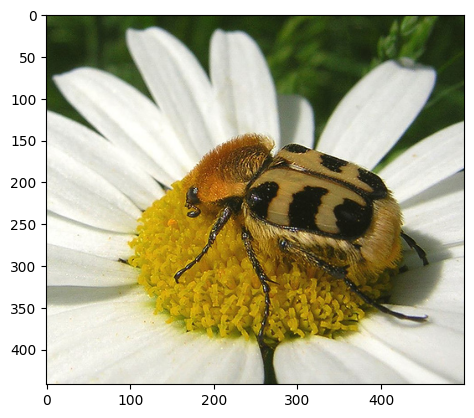

In [16]:
img, label = dataset[120]
plt.imshow(img)

In [17]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64),
                                            tt.RandomCrop(64),
                                            tt.ToTensor()]))

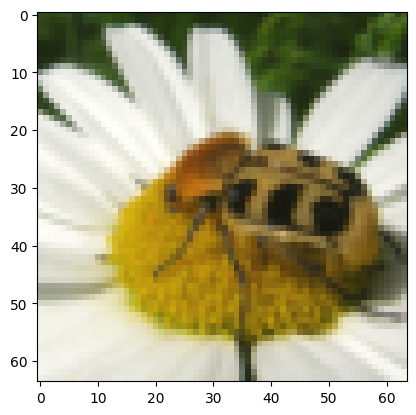

In [18]:
img, label = dataset[120]
plt.imshow(img.permute((1, 2, 0)))

In [19]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(3886, 431)

In [20]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(3886, 431)

In [21]:
from torch.utils.data import DataLoader

batch_size = 128

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)

valid_dl = DataLoader(valid_ds,
                    batch_size,
                    num_workers=4,
                    pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [22]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

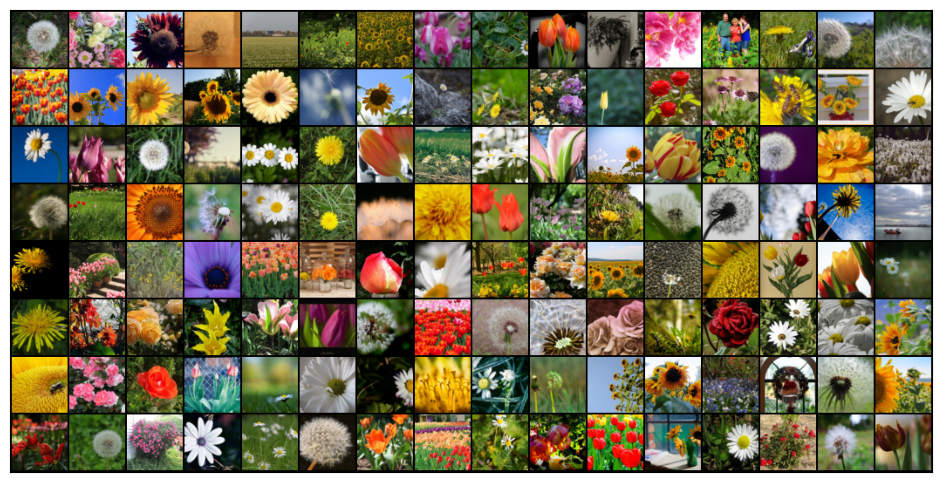

In [23]:
show_batch(train_dl)

In [24]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [25]:
torch.cuda.is_available()

True

In [26]:
device = get_default_device()

In [27]:
device

device(type='cuda')

In [28]:
img, label = dataset[0]

In [29]:
img.device

device(type='cpu')

In [30]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [31]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [32]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [33]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [34]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32

        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [35]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [36]:
model.conv1[0].weight.device

device(type='cuda', index=0)

Pass one batch of input tensor through the model.

In [37]:
torch.cuda.empty_cache()
for batch in train_dl:
    images, labels = batch
    print('images.shape', images.shape)
    print('images.device', images.device)
    preds = model(images)
    print('preds.shape', preds.shape)
    break

images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 5])


Training


In [38]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.6161081790924072, 'val_acc': 0.18209773302078247}]

In [39]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.5061, val_loss: 1.5188, val_acc: 0.3806
Epoch [1], train_loss: 0.9608, val_loss: 0.8558, val_acc: 0.6666
Epoch [2], train_loss: 0.9061, val_loss: 1.0261, val_acc: 0.6464
Epoch [3], train_loss: 0.7584, val_loss: 0.7496, val_acc: 0.7126
Epoch [4], train_loss: 0.7048, val_loss: 0.7174, val_acc: 0.7437


In [40]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.9388, val_loss: 0.7097, val_acc: 0.7593
Epoch [1], train_loss: 0.6997, val_loss: 0.8736, val_acc: 0.6798
Epoch [2], train_loss: 0.6129, val_loss: 0.6747, val_acc: 0.7512
Epoch [3], train_loss: 0.5528, val_loss: 0.6429, val_acc: 0.7652
Epoch [4], train_loss: 0.4990, val_loss: 0.7402, val_acc: 0.7646


In [41]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.5906, val_loss: 0.8631, val_acc: 0.6945
Epoch [1], train_loss: 0.4709, val_loss: 0.6129, val_acc: 0.7788
Epoch [2], train_loss: 0.4200, val_loss: 0.5782, val_acc: 0.7749
Epoch [3], train_loss: 0.4083, val_loss: 0.5791, val_acc: 0.7875
Epoch [4], train_loss: 0.3792, val_loss: 0.5987, val_acc: 0.7456


In [42]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.3919, val_loss: 0.6599, val_acc: 0.7730
Epoch [1], train_loss: 0.3132, val_loss: 0.4817, val_acc: 0.8314
Epoch [2], train_loss: 0.2868, val_loss: 0.5305, val_acc: 0.8202
Epoch [3], train_loss: 0.2718, val_loss: 0.6589, val_acc: 0.8026
Epoch [4], train_loss: 0.2492, val_loss: 0.5357, val_acc: 0.8104


In [43]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.2962, val_loss: 0.5896, val_acc: 0.7900
Epoch [1], train_loss: 0.2076, val_loss: 0.6195, val_acc: 0.8216
Epoch [2], train_loss: 0.2222, val_loss: 0.4855, val_acc: 0.8470
Epoch [3], train_loss: 0.1586, val_loss: 0.5581, val_acc: 0.8216
Epoch [4], train_loss: 0.1557, val_loss: 0.6102, val_acc: 0.8095


In [44]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.2141, val_loss: 0.7390, val_acc: 0.8017
Epoch [1], train_loss: 0.1288, val_loss: 0.5432, val_acc: 0.8300
Epoch [2], train_loss: 0.1331, val_loss: 0.6937, val_acc: 0.7881
Epoch [3], train_loss: 0.1343, val_loss: 0.6568, val_acc: 0.7973
Epoch [4], train_loss: 0.1063, val_loss: 0.6817, val_acc: 0.8101


In [45]:
history += fit(5, 0.0001, model, train_dl, valid_dl)


Epoch [0], train_loss: 0.0826, val_loss: 0.5697, val_acc: 0.8218
Epoch [1], train_loss: 0.0716, val_loss: 0.5264, val_acc: 0.8461
Epoch [2], train_loss: 0.0874, val_loss: 0.5497, val_acc: 0.8310
Epoch [3], train_loss: 0.0833, val_loss: 0.5235, val_acc: 0.8243
Epoch [4], train_loss: 0.0759, val_loss: 0.4979, val_acc: 0.8539


In [46]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

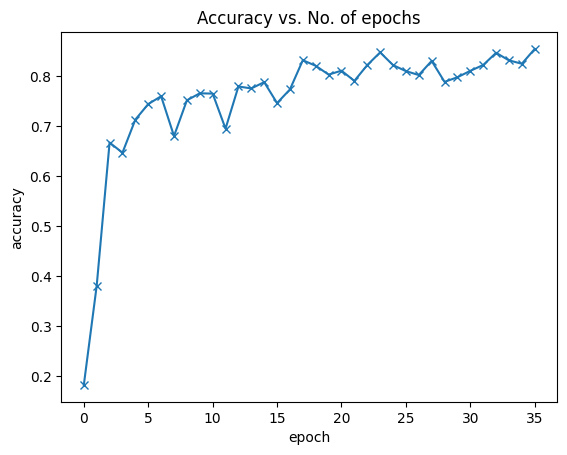

In [47]:
plot_accuracies(history)

In [48]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

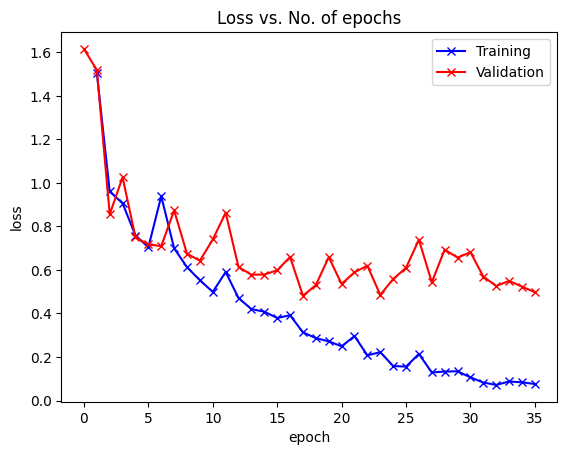

In [49]:
plot_losses(history)

In [50]:
history[-1]

{'val_loss': 0.4978574216365814,
 'val_acc': 0.853931188583374,
 'train_loss': 0.07586550712585449}

In [51]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [52]:
def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction:', pred)

Target: sunflower
Prediction: sunflower


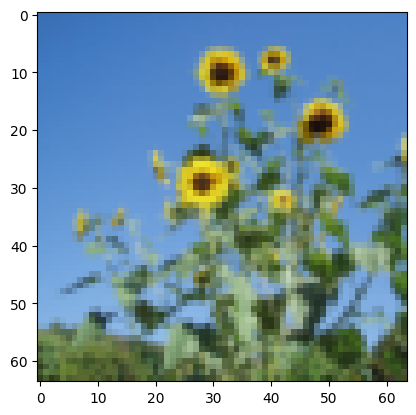

In [53]:
show_image_prediction(*valid_ds[100])

Target: sunflower
Prediction: sunflower


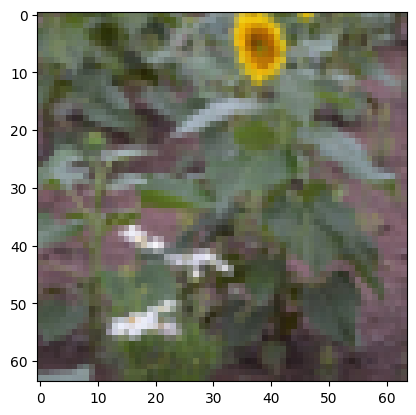

In [54]:
show_image_prediction(*valid_ds[120])

Target: tulip
Prediction: tulip


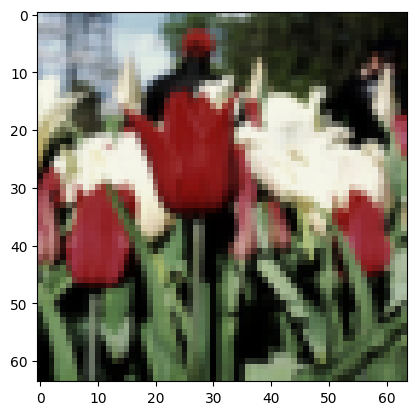

In [55]:
show_image_prediction(*valid_ds[50])

Target: rose
Prediction: rose


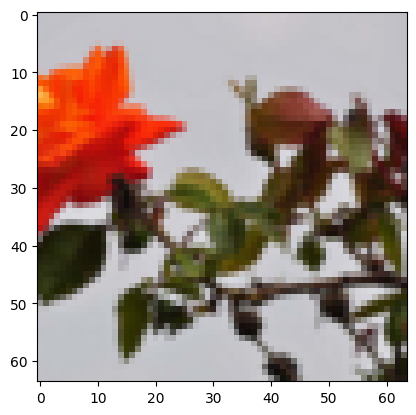

In [56]:
show_image_prediction(*valid_ds[210])

Target: tulip
Prediction: tulip


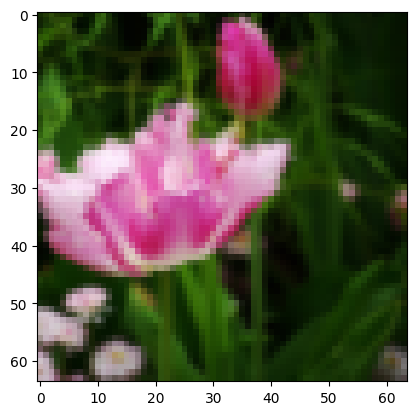

In [59]:
show_image_prediction(*valid_ds[415])

In [60]:
torch.save(model.state_dict(), 'flowers-resnet9.pth')